# Dataset Example-based explanations

For a batch of $B$ sequences of length $L$, each sampled from a different episode, the observations that maximize the activity of each categorical distribution are displayed, for a trained model.

## Strategy

1. Sample a batch of shape ${[}B,L,C,K{]}$ of $B$ observations, each denoting a rollout of length $L$, and compute the corresponding RSSM activations, denoted by $C$ categorical distributions with $K$ classes each.
2. Flatten the batched activations to a matrix of shape ${[}BLC,K{]}$, so that exampled-based explanations can be generated independent from the specific class $C$.
3. Apply Non-negative Matrix Factorization to the resulting matrix, with rank $r$.
4. For each rollout of length $L$, highlight the most important observations, according to the magnitude ($\ell_2$-norm) of the corresponding activations.

In [2]:
import os

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchnmf.nmf import NMF
from IPython.display import Image, display

from dreamerv2.models.rssm import RSSMDiscState
from dreamerv2.training.config import MinAtarConfig
from dreamerv2.training.evaluator import Evaluator
from dreamerv2.utils.wrapper import GymMinAtar, OneHotAction, freewayPOMDP

env_name = "freeway"
exp_id = "0_pomdp"
device = "cuda:0"
rank=10

ACTIONS = {
    0: "STAY",
    1: "UP",
    2: "DOWN",
}

In [3]:
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
result_dir = os.path.join("../results_official", f"{env_name}_{exp_id}")
model_dir = os.path.join(result_dir, "models")
f = "models_best.pth"

config = MinAtarConfig(
    env=env_name,
    obs_shape=env.observation_space.shape,
    action_size=env.action_space.shape[0],
    obs_dtype=bool,
    action_dtype=np.float32,
    model_dir=model_dir,
    eval_episode=10,
    eval_render=False,
)

evaluator = Evaluator(config, device)
evaluator.load_model(evaluator.config, os.path.join(model_dir, f))

In [5]:
score = 0
done = False
history = []
torch.set_grad_enabled(False)

# Produce always same episode
env = freewayPOMDP(OneHotAction(GymMinAtar(env_name)))
env.env.env.seed(21)
torch.manual_seed(31)

# [2, 10, 10]
obs = env.reset()

# Initial RSSM state (all zeros):
# state.deter [1, 200]
# state.logit [1, 400] (20 categegoricals, 20 classes each)
# state.stoch [1, 400] (20 one-hot samples, sampled from logit)
prev_rssm_state = evaluator.RSSM._init_rssm_state(batch_size=1)

# [1, 3]
prev_action = torch.zeros(1, evaluator.action_size).to(evaluator.device)

for _ in range(config.seq_len):
    # Embed observation, [1, 200]
    embed = evaluator.ObsEncoder(
        torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(evaluator.device)
    )

    # During evaluation, use the posterior state, i.e. the one obtained using the current observation.
    _, posterior_rssm_state = evaluator.RSSM.rssm_observe(
        embed, prev_action, not done, prev_rssm_state
    )

    # Concat deter+stoch state [1, 600]
    model_state = evaluator.RSSM.get_model_state(posterior_rssm_state)

    # The history consists of:
    # current obs         o_t
    # current state       h_t, s_t
    # predicted action    a_t
    # internal move timer (will the action actually have effect?)
    action, _ = evaluator.ActionModel(model_state)
    
    history.append(
        (
            obs,
            RSSMDiscState(
                posterior_rssm_state.logit.cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.stoch.cpu().squeeze(0).reshape(20, 20),
                posterior_rssm_state.deter.cpu().squeeze(0),
            ),
            action.squeeze(0).cpu().numpy(),
            env.env.env.env.env.move_timer == 0,
        )
    )

    obs, reward, done, _ = env.step(action.squeeze(0).cpu().numpy())
    score += reward
    prev_rssm_state = posterior_rssm_state
    prev_action = action

score, len(history)

(0, 50)

In [19]:
# stack logits
logits = torch.stack([ state[1].logit for state in history ], dim=0).to(device)

# normalize the logits, required by NMF (each entry must be non-negative)
logits = logits.softmax(dim=2)

# reshape logits
logits = logits.reshape(-1, config.rssm_info['category_size'])
logits.requires_grad_(True)
torch.set_grad_enabled(True)

# factorize matrix
model = NMF(logits.t().shape, rank=rank).to(device)
model.fit(logits.t())
torch.set_grad_enabled(False)

# compute l2-norm of each column of model.H.t()
activations = torch.norm(model.W @ model.H.t(), p=2, dim=1).reshape(-1, 20)
max_act = torch.max(activations.view(-1))
activations = (activations / max_act).cpu().numpy()

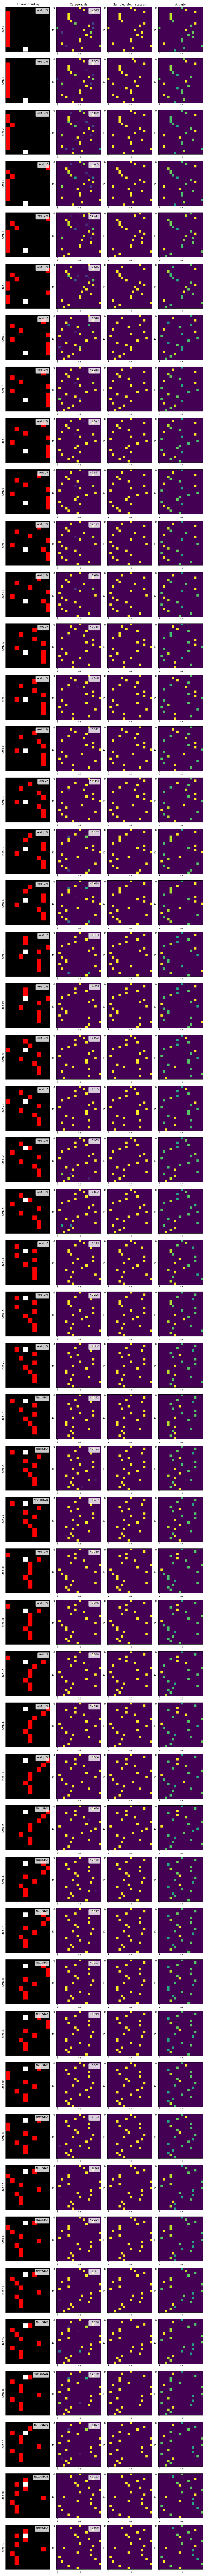

In [22]:
def render_freeway(obs):
    buf = np.zeros((10, 10, 3), dtype=np.uint8)
    buf[obs[0]] = (255, 255, 255)
    buf[obs[1]] = (255, 0, 0)
    return buf


fig, axs = plt.subplots(len(history), 4, figsize=(12, 3 * len(history)))
axs[0, 0].set_title("Environment $o_t$")
axs[0, 1].set_title("Categoricals")
axs[0, 2].set_title("Sampled stoch state $s_t$")
axs[0, 3].set_title("Activity")

for t, axs_row in enumerate(axs):
    obs, posterior_rssm_state, action, has_effect = history[t]

    ax = axs_row[0]
    ax.imshow(render_freeway(obs))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Step {t}")
    ax.legend(
        [],
        loc="upper right",
        title=(
            # If the action is in () it means that it will
            # actually have no effect due to the game timer.
            f"Next {ACTIONS[action.argmax()]}"
            if has_effect
            else f"Next ({ACTIONS[action.argmax()]})"
        ),
    )

    ax = axs_row[1]
    ax.imshow(posterior_rssm_state.logit.softmax(-1).numpy(), vmin=0, vmax=1)
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    e = (
        torch.distributions.Categorical(logits=posterior_rssm_state.logit)
        .entropy()
        .sum()
        .item()
    )
    ax.legend([], loc="upper right", title=f"H {e:.3f}")

    ax = axs_row[2]
    ax.imshow(posterior_rssm_state.stoch.numpy(), vmin=0, vmax=1)
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    
    # for each categorical distribution, assign to the sampled class the corresponding activity, normalized
    ax = axs_row[3]
    ax.imshow(posterior_rssm_state.stoch.numpy() / (posterior_rssm_state.stoch.numpy() + 1e-10) * activations[t], vmin=0, vmax=1)
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])

fig.tight_layout()
fig.savefig("freeway_example-based.png")
plt.close(fig)
display(Image("freeway_example-based.png", width=1000))